In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
sns.set_theme(style="whitegrid", font_scale=2)

In [9]:
trf_score_paths = list(Path("../outputs/notebooks").glob("*/*/*/*/trf/trf_scores.csv"))
print(trf_score_paths)
trf_scores = pd.concat([pd.read_csv(p) for p in trf_score_paths],
                       keys=[(p.parents[1].name, p.parents[2].name, p.parents[3].name) for p in trf_score_paths],
                       names=["equivalence", "model", "base_model"]).reset_index(level=3, drop=True)
trf_scores = trf_scores.reset_index().melt(id_vars=["base_model", "model", "equivalence", "fold"], var_name="output_dim", value_name="score").dropna()

trf_scores["model"] = trf_scores.model.str.replace("random[^_]*_", "", regex=True)

trf_scores

[PosixPath('../outputs/notebooks/timit/w2v2_6/rnn_8-regularization_cov1000/phoneme/trf/trf_scores.csv'), PosixPath('../outputs/notebooks/timit/w2v2_6/rnn_8-weightdecay0.01/next_phoneme_10frames/trf/trf_scores.csv'), PosixPath('../outputs/notebooks/timit/w2v2_6/rnn_8-weightdecay0.01/word_broad_10frames/trf/trf_scores.csv'), PosixPath('../outputs/notebooks/timit/w2v2_6/rnn_8/phoneme_10frames/trf/trf_scores.csv'), PosixPath('../outputs/notebooks/timit/w2v2_6/randomrnn_32/random/trf/trf_scores.csv'), PosixPath('../outputs/notebooks/timit/w2v2_6/rnn_3/phoneme_10frames/trf/trf_scores.csv'), PosixPath('../outputs/notebooks/timit/w2v2_6/randomff_32/random/trf/trf_scores.csv'), PosixPath('../outputs/notebooks/timit/w2v2_6/rnn_3-weightdecay0.01/next_phoneme_10frames/trf/trf_scores.csv'), PosixPath('../outputs/notebooks/timit/w2v2_6/rnn_3-weightdecay0.01/phoneme_10frames/trf/trf_scores.csv'), PosixPath('../outputs/notebooks/timit/w2v2_6/randomrnn_8/random/trf/trf_scores.csv'), PosixPath('../outpu

,base_model,model,equivalence,fold,output_dim,score
0,w2v2_6,rnn_8-regularization_cov1000,phoneme,0,0,0.404112
1,w2v2_6,rnn_8-regularization_cov1000,phoneme,1,0,0.396652
2,w2v2_6,rnn_8-regularization_cov1000,phoneme,2,0,0.401436
3,w2v2_6,rnn_8-weightdecay0.01,next_phoneme_10frames,0,0,0.382695
4,w2v2_6,rnn_8-weightdecay0.01,next_phoneme_10frames,1,0,0.375984
...,...,...,...,...,...,...
1036,w2v2_6,32,random,1,31,0.150535
1037,w2v2_6,32,random,2,31,0.147013
1041,w2v2_6,32,random,0,31,0.142886
1042,w2v2_6,32,random,1,31,0.142885


In [17]:
trf_scores.equivalence.unique()

array(['phoneme', 'next_phoneme_10frames', 'word_broad_10frames',
       'phoneme_10frames', 'random'], dtype=object)

In [10]:
score_summary = trf_scores.groupby(["base_model", "model", "equivalence", "fold"]).apply(lambda xs: pd.Series({"mean_score": xs.score.mean(), "num_dimensions": xs.output_dim.nunique()}))
score_summary

mean_score  \
base_model model                        equivalence           fold               
w2v2_6     32                           random                0       0.147738   
                                                              1       0.146209   
                                                              2       0.146874   
           8                            random                0       0.153483   
                                                              1       0.151506   
                                                              2       0.152569   
           rnn_3                        phoneme_10frames      0       0.576159   
                                                              1       0.568949   
                                                              2       0.570636   
           rnn_3-weightdecay0.01        next_phoneme_10frames 0       0.367280   
                                                              1       0.360915   
                                                              2       0.367735   
                                        phoneme_10frames      0       0.583421   
                                                              1       0.576331   
                                                              2       0.579988   
           rnn_8                        phoneme_10frames      0       0.578457   
                                                              1       0.572828   
                                                              2       0.575413   
           rnn_8-regularization_cov1000 phoneme               0       0.513971   
                                                              1       0.506237   
                                                              2       0.511706   
           rnn_8-weightdecay0.01        next_phoneme_10frames 0       0.344005   
                                                              1       0.337957   
                                                              2       0.342115   
                                        word_broad_10frames   0       0.101596   
                                                              1       0.099480   
                                                              2       0.100527   

                                                                    num_dimensions  
base_model model                        equivalence           fold                  
w2v2_6     32                           random                0               32.0  
                                                              1               32.0  
                                                              2               32.0  
           8                            random                0                8.0  
                                                              1                8.0  
                                                              2                8.0  
           rnn_3                        phoneme_10frames      0                3.0  
                                                              1                3.0  
                                                              2                3.0  
           rnn_3-weightdecay0.01        next_phoneme_10frames 0                3.0  
                                                              1                3.0  
                                                              2                3.0  
                                        phoneme_10frames      0                3.0  
                                                              1                3.0  
                                                              2                3.0  
           rnn_8                        phoneme_10frames      0                8.0  
                                                              1                8.0  
                                                              2           

/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)
/home/jgauthier/u/transformers/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  self._figure.tight_layout(*args, **kwargs)


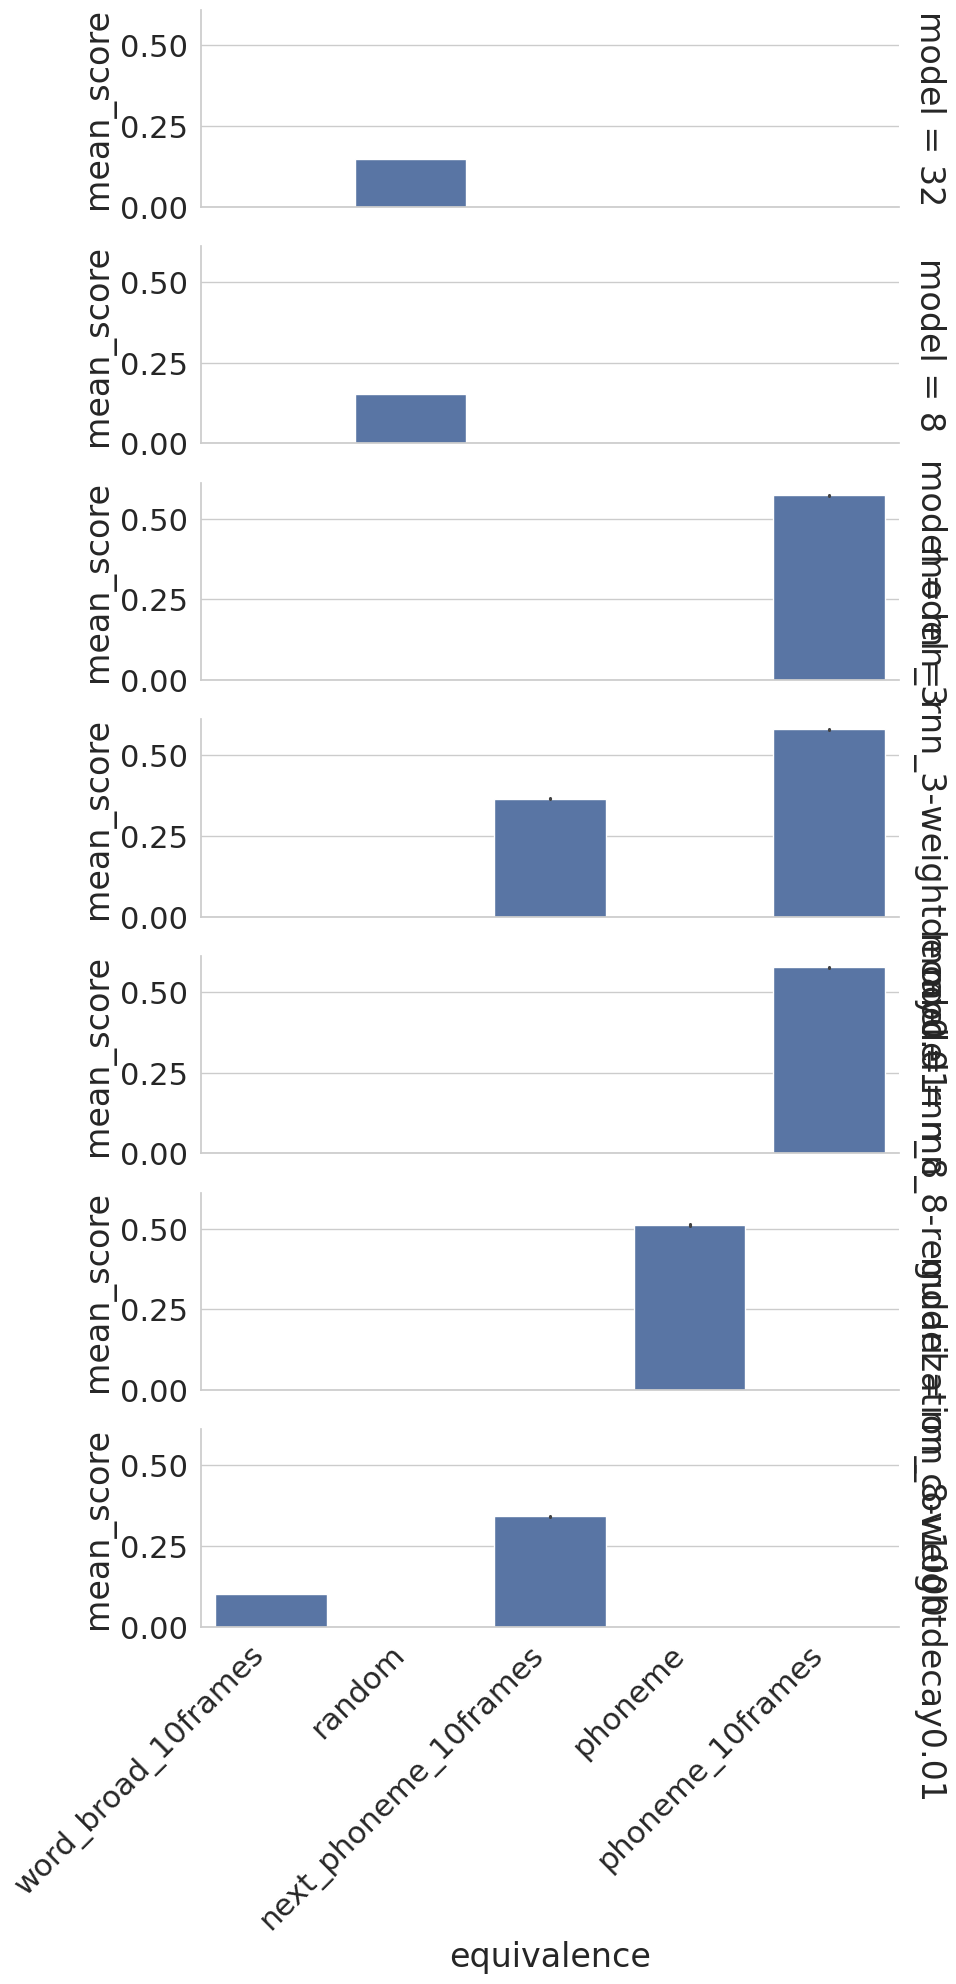

In [11]:
g = sns.FacetGrid(data=score_summary.reset_index(), row="model", margin_titles=True, aspect=3)
g.map(sns.barplot, "equivalence", "mean_score", order=score_summary.groupby("equivalence").mean().sort_values("mean_score").index, errorbar="se")

for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(45)
        label.set_ha("right")

Text(0.5, 0, 'Model')

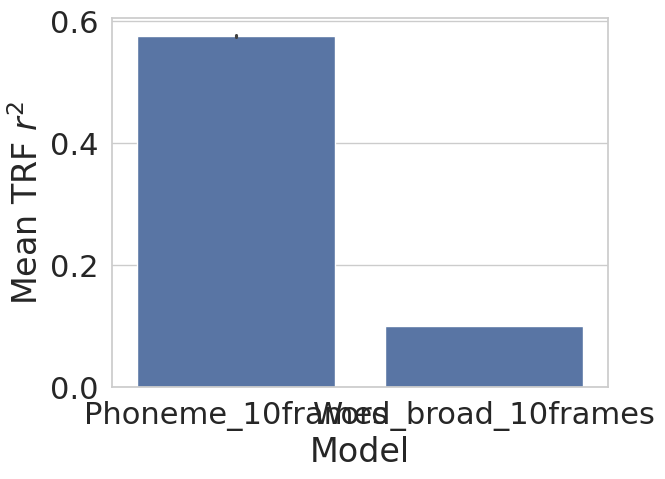

In [15]:
plot_data = score_summary.reset_index()
# plot_data = plot_data[plot_data.model == "w2v2_6_8"]
plot_data = plot_data[plot_data.equivalence.isin(["word_broad_10frames", "syllable_10frames", "phoneme_10frames"])]
plot_data["equivalence"] = plot_data.equivalence.str.capitalize()

# Get mean and standard error of random model
# random_mean = score_summary.loc["w2v2_6_8"].loc["random"].mean_score.mean()
# random_se = score_summary.loc["w2v2_6_8"].loc["random"].mean_score.sem()

ax = sns.barplot(data=plot_data, x="equivalence", y="mean_score", errorbar="se")
ax.set_ylabel("Mean TRF $r^2$")
ax.set_xlabel("Model")

# Plot region of random performance
# ax.axhspan(random_mean - random_se, random_mean + random_se, color=sns.color_palette()[1])

In [7]:
ci??

Object `ci` not found.


## Feature selection results

In [19]:
feature_selection_paths = list(Path("../outputs/notebooks").glob("*/*/trf/trf_feature_selection_trajectory.csv"))
feature_selection = pd.concat([pd.read_csv(p) for p in feature_selection_paths],
                              keys=[(p.parents[2].name, p.parents[1].name) for p in feature_selection_paths],
                              names=["model", "equivalence"])

# feature_selection["model"] = feature_selection.model.str.replace("random[^_]*_", "", regex=True)

feature_selection.index.set_names("selection_idx", level=-1, inplace=True)
feature_selection = feature_selection.sort_index().reset_index()
feature_selection["model"] = feature_selection.model.str.replace("random[^_]*_", "", regex=True)

# Compute score deltas
feature_selection["score_diff"] = feature_selection.score.diff()
# Correct for boundaries
feature_selection.loc[feature_selection.selection_idx == 0, "score_diff"] = 0

feature_selection.head(10)

,model,equivalence,selection_idx,Unnamed: 0,category,score,score_diff
0,w2v2_6_32,random,0,0,NaN,0.017284,0.000000
1,w2v2_6_32,random,1,1,consonant_manner,0.072362,0.055078
2,w2v2_6_32,random,2,2,consonant_place,0.108654,0.036291
3,w2v2_6_32,random,3,3,vowel,0.126491,0.017838
4,w2v2_6_8,random,0,0,NaN,0.015372,0.000000
5,w2v2_6_8,random,1,1,consonant_place,0.080950,0.065578
6,w2v2_6_8,random,2,2,consonant_manner,0.114248,0.033298
7,w2v2_6_8,random,3,3,vowel,0.130620,0.016371
8,w2v2_6_32,random,0,0,NaN,0.019205,0.000000
9,w2v2_6_32,random,1,1,consonant_manner,0.099420,0.080214


In [20]:
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

plot_data = feature_selection[(feature_selection.model == "w2v2_6_8")]
plot_data["category"] = plot_data.category.fillna("baseline")

/tmp/ipykernel_4007273/3410982662.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["category"] = plot_data.category.fillna("baseline")


In [22]:
links = []
for (model, equivalence), rows in plot_data.groupby(["model", "equivalence"]):
    for i1, i2 in zip(rows.index, rows.index[1:]):
        links.append({"source": rows.loc[i1].category, "target": rows.loc[i2].category, "value": rows.loc[i2, "score_diff"],
                      "type": f"{model} {equivalence}"})

# layout = Layout(width="1500", height="1200")
SankeyWidget(links=links)#, linkLabelFormat=".2f", layout=layout)

SankeyWidget(links=[{'source': 'baseline', 'target': 'consonant_manner', 'value': 0.4961562442384103, 'type': …